# Exploratory Data Analysis on Yelp Dataset

## The goal of the project is to build an app that allows a user to find local resturants and eateries that specialize in a specific dish. This could be anything - bagels, pizza, chicken wings, tacos. We are looking to redefine what it means for a resturant to be "good", as many resturants specialize in certain dishes.

## The dataset can be found at https://www.yelp.com/dataset.

In [945]:
import numpy as np
import scipy
import pandas as pd
import dask.bag as db
import json
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import mplleaflet
from scipy.special import factorial as factorial
%matplotlib notebook
pd.set_option('display.max_columns', None)

### The first order of business is to load in the yelp data into our notebook. This requires first extracting all the json files from the compressed data set. Next, we find the two json files we are most interested in. 

### 'yelp_academic_dataset_business.json' holds all the business IDs, latitude and longitude coordinates, and names of the resturants.

### 'yelp_academic_dataset_review.json' is 6.33GB, and holds all the business ids and individual reviews of the resturant. In order to easily import in this large dataset, we split the data into chunks of 350000 reviews via "split -l 350000 yelp_academic_dataset_review.json, then import them all in while dropping catagories we don't want and are taking up memory, like 'review_id' and 'useful' catagories. 

In [481]:
business_data = pd.read_json('yelp_academic_dataset_business.json',lines=True)

In [485]:
data = pd.DataFrame()
names = ['xaa','xab','xac','xad','xae','xaf','xag','xah','xai','xaj','xak','xal','xam','xan','xao','xap', \
        'xaq','xar','xas','xat','xau','xav','xaw']
for filename in names:
    df = pd.read_json(filename,lines=True)
    df.drop('review_id', axis=1,inplace=True)
    df.drop('useful', axis=1,inplace=True)
    data = data.append(df)

### We next drop the data that we don't want form the business dataset, and filter by category so that we only are looking at businesses that provide some kind of food service

In [974]:
business_data.drop('review_count',axis=1,inplace=True)
business_data.drop('attributes',axis=1,inplace=True)
business_data = business_data[business_data['categories'].notna()]
food_business_data = business_data[business_data['categories'].str.contains('Resturants|Food|Bars|Ice Cream|Frozen Yogurt|Coffee|Tea|Diners',regex=True)]
Food_review_data = pd.merge(food_business_data,data,how='inner',on='business_id')
Food_review_data['text'] = Food_review_data['text'].str.lower()

In [975]:
Food_review_data.head()

,address,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,stars_x,state,cool,date,funny,stars_y,text,user_id,Parm
0,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2013-04-11 18:36:15,0,5,i love the empanadas from the empanadas house!...,eSQ3z93DlzkpXK_H6MFEMw,False
1,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2017-09-21 17:45:53,0,5,i ordered feta cheese and spinach empanadas an...,5So3uZiWDmow4eG8Va0WhQ,False
2,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2014-10-07 01:07:00,0,2,i went to the place on green st today. i went ...,Oh1CPqH5zBZfDEC_2ueTow,False
3,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2013-07-10 18:26:33,0,5,these empanadas are excellent- we are argentin...,vtqj_61x-cpLjrj1dBQTjQ,False
4,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2019-05-07 03:12:10,0,5,these empanadas are huge and in my opinion bet...,aVWzh3hpLVUSVWSds75Sig,False


## We will restrict our analysis to the city of Toronto (for illustrative purposes)

In [976]:
Toronto = Food_review_data[Food_review_data['city'] == 'Toronto']

#### Before we go further, we want to build a bayesian model for analysis. The goal is to find the posterior probability that given the data we collect, we will like the specific dish we are interested in. Consider as an example, tacos. 



# $P($good tacos$ \vert$review data$) = P($review data$ \vert$ good tacos$) *  P($good tacos$)  /  P($review data$)$
 
 
 
 
#### The probability of someone getting good tacos at the resturant is proportional to the likelihood of the data times the prior.
 
#### Our model for the likelihood will be to use a truncated version of the poisson distribution, where we restrict the values to be between 0 and 4 (corresponding stars 1 to 5) by dividing by a partition function Z

In [916]:
def Z(lam):
    return np.exp(-lam)*(1 + lam + lam**2/2 + lam**3/6 + lam**4/(6*4))

def poisson_prob(lam):
    vec = []
    for k in range(5):
        vec.append(lam**k * np.exp(-lam)/(Z(lam)*np.math.factorial(k)))
    return vec

def likelihood(lam,k):
    logprob = (k*np.log(lam) - lam - np.log(Z(lam)) - np.log(factorial(k))).sum()
    return logprob

 ## We can interactivly examine how the probability distribution changes as we shift the lambda value

<IPython.core.display.Javascript object>


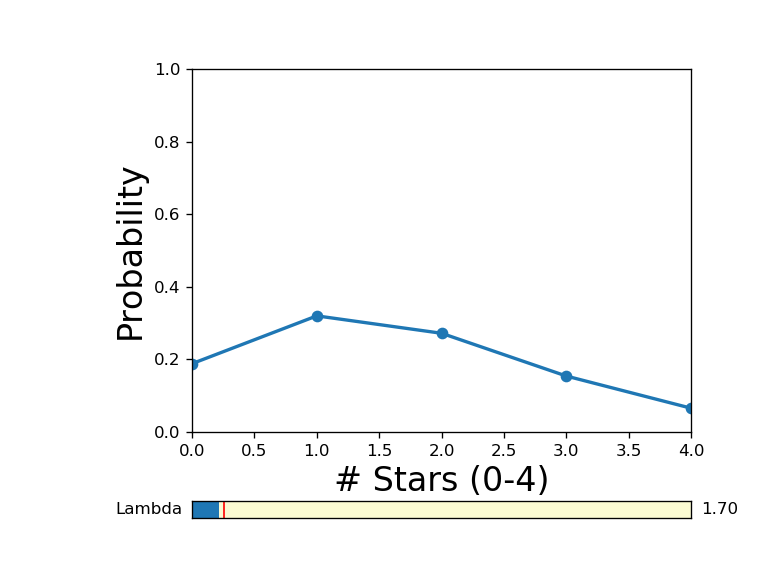

In [1066]:
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)


l, = plt.plot(poisson_prob(3), 'o-',lw=2)
plt.ylim([0,1])
ax.margins(x=0)

plt.xlabel('# Stars (0-4)',size=20)
plt.ylabel('Probability',size=20)
lamfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)


lam = Slider(lamfreq, 'Lambda', 0.1, 30.0, valinit=2, valstep=.1)



def update(val):
    lamval = lam.val
    l.set_ydata(poisson_prob(lamval))
    fig.canvas.draw_idle()


lam.on_changed(update)



plt.show()

### Say we are interested in finding the best tacos in Toronto. We would search the database for any mention of tacos, including mispellings, or related items, and return a list of the business indexes corresponding to these

In [977]:
businesses = Toronto[Toronto['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)]['business_id'].value_counts().index.to_list()


### We can use a bayesian  model in order to sample from the posterior distribution. Here, we use the total resturant reviews in order to inform the prior distribution of the quality of the individual dish. This should make intutive sense - the better the resturant is, the more likely it will be that a specific dish is good. The worse a resturant is, the less likely. By using the total resturant information as the prior, we are biasing our results towards the general quality of the resturant. But if a specific dish is really good (or really bad), this will show up when we calculate the likelihood


# $P(\lambda_{taco} \vert $reviews$) \propto P($reviews of tacos$ \vert \lambda_{taco}) * P(\lambda_{all} \vert $reviews$)$

### Where the likelihood is defined as

# $P($reviews $\vert \lambda)$ = $\prod P(k_{stars}, \lambda)$ = $\prod \lambda^k e^{-\lambda}/Zk! $

### with k the number of stars awarded (from 0 to 4) and Z the normalization so the probability sums to 1

In [982]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

def likelihood(lam,k):
    logprob = (k*np.log(lam) - lam - np.log(Z(lam)) - np.log(factorial(k))).sum()
    return logprob


    
    
    

### We can test this one just a single business to start

In [1010]:
sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_resturant = pm.Uniform('lam_rest',0,10)
    y_obs_2 = pm.Potential('y_obs_2',likelihood(lam_resturant,np.array(allstars)-1))
    
    lam_taco = pm.Normal('lam_tacos',mu=lam_resturant,sd=np.sqrt(lam_resturant))
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5247.64draws/s]


### And see what the predicted taco score is ($\lambda_{taco}$ in the model). These plots give the probability density of specific parameters, along with the sampling paths for each parameter. This gives us far more information than just a mean and standard deviation, which could be used in further analysis to fine tune our scoring

<IPython.core.display.Javascript object>


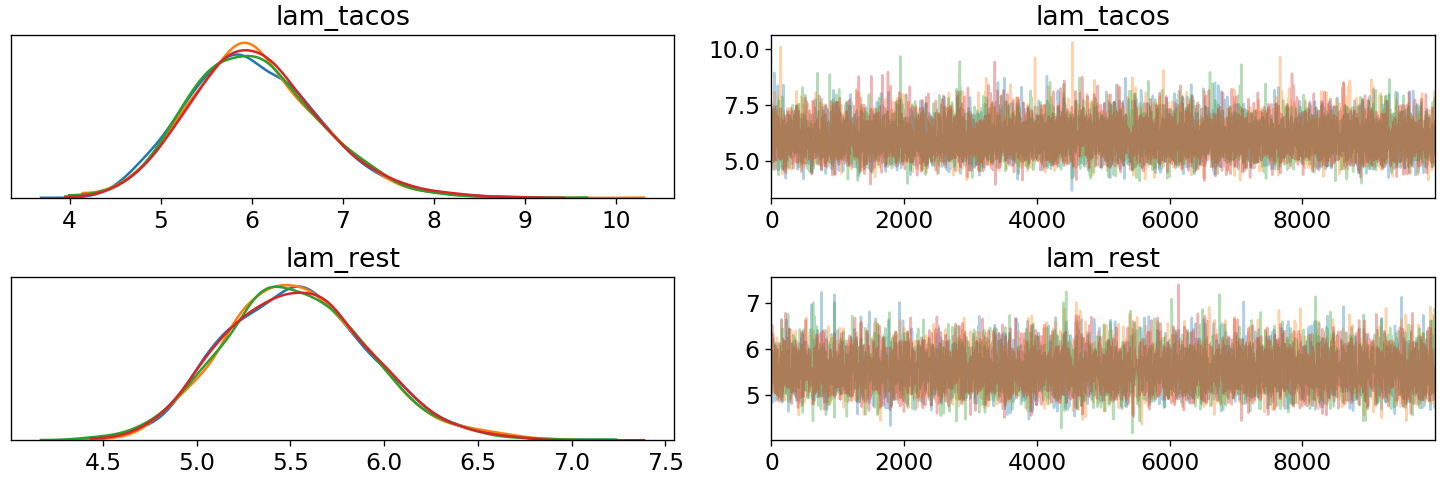

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2da3242e8>,
      dtype=object)

In [1011]:
pm.traceplot(trace)

In [1012]:
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_tacos,6.036,0.710,4.831,7.368,0.008,0.006,8483.0,8307.0,8682.0,8942.0,1.0
lam_rest,5.537,0.381,4.859,6.214,0.004,0.003,8203.0,8164.0,8272.0,8746.0,1.0


### A key question would be to see if this actually does any better at predicting how highly people will rate tacos. We can compare it to just the base model. Here, we actually see that the resturant in question scores higher for its tacos than it does overall! Those must be good tacos

### Another question is, would we just be better off using the taco only data?

In [1067]:
sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_taco = pm.Uniform('lam_rest',0,10)
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:07<00:00, 7884.50draws/s]


<IPython.core.display.Javascript object>


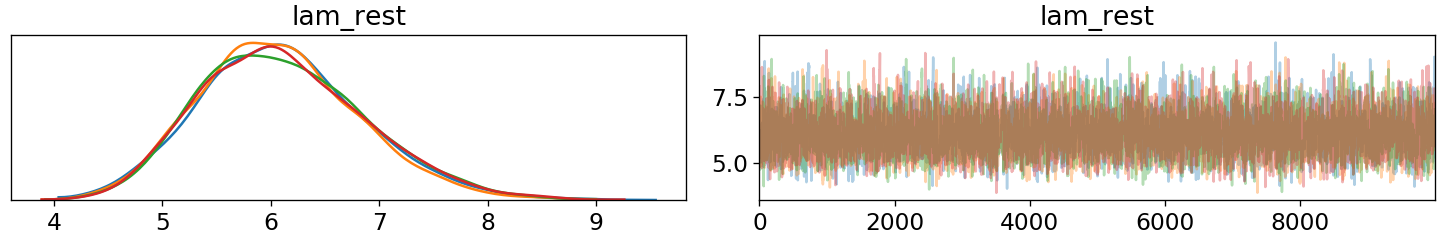

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e5240630>,
      dtype=object)

In [1068]:
pm.traceplot(trace)

In [1016]:
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_rest,6.097,0.741,4.806,7.471,0.008,0.006,7739.0,7552.0,8017.0,8239.0,1.0


### We can see here that the general resturant reviews, being not as good as the taco reviews, pulled the taco reviews down slightly. It's a minor effect, but would play a bigger role if we had a small number of taco reviews for the resturant

In [1022]:
len(tacostars)

6

### Now we get to the meat, which would be to take each business that mentions tacos, and review them, and then rank them by this taco score. We save all the taco scores in a dictonary for further use

In [ ]:
tacoscore_dict = {}

for business in businesses:
    sb = Toronto[Toronto['business_id'] == business]
    allstars = sb.stars_y.to_list() 
    fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)]
    
    
    with pm.Model() as test_model:

        lam_resturant = pm.Uniform('la m_rest',0,10)
        y_obs_2 = pm.Potential('y_obs_2',likelihood(lam_resturant,np.array(allstars)-1))
    
        lam_taco = pm.Normal('lam_tacos',mu=lam_resturant,sd=np.sqrt(lam_resturant))
        y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(tacostars)-1))
   

    with test_model:
        step = pm.Metropolis()
        trace = pm.sample(10000,step=step,tune=5000)
        
    print('Business id =', business, '   Taco Score = ',az.summary(trace,varnames,credible_interval=.93).round(3)['mean'][0])
    tacoscore_dict.update({business : az.summary(trace,varnames,credible_interval=.93).round(3)['mean'][0]})

In [1027]:
Toronto['Taco Score'] = Toronto['business_id'].map(tacoscore_dict)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1028]:
Tacos = Toronto.groupby('name').mean().sort_values('Taco Score',ascending=False)
Tacos = Tacos[Tacos['Taco Score'].notna()]

## Now we can see what our search came up with

In [1031]:
Tacos['Taco Score']

name
Alo Restaurant                                 3.144
Her Father's Cider Bar & Kitchen               3.140
El Nahual Tacos                                3.137
Kozlik's Canadian Mustard                      3.136
Beach Hill Smokehouse                          3.110
Yasu                                           3.107
Scaramouche Restaurant Pasta Bar & Grill       3.097
ChocoSol Traders                               3.086
Boralia                                        3.082
Blaze Fast-Fire'd Pizza                        3.078
Pomarosa Coffee Shop & Kitchen                 3.077
Nom Nom Nom Poutine                            3.075
Infuse Cafe Bar                                3.068
Agio                                           3.068
Superfood Eateries                             3.067
Mana'ish Global Flatbread Cafe                 3.063
The Tilted Dog Pub & Kitchen                   3.055
M&J's Eastside Deli                            3.050
Café Polonez                             

## This is a decent enough list, and captures many of the good taco places in Toronto. But, for instance, it cannot yet distinguish between a resturant that specializes in tacos from just a very good resturant, like Alo (which doesn't have traditional tacos). We can weight it by both the ratio of number of reviews of tacos to improve the accuracy 

In [1087]:
ratiodict = {}
numstarsdict = {}
for business in businesses:
    sb = Toronto[Toronto['business_id'] == business]
    allstars = sb.stars_y.to_list() 
    fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)]
    ratiodict.update({business : len(fooditem_stars)/len(allstars)})
    numstarsdict.update({business : len(allstars)})

In [1088]:
Toronto['ratio'] = Toronto['business_id'].map(ratiodict)
Toronto['numreviews'] = Toronto['business_id'].map(numstarsdict)
Tacos = Toronto.groupby('name').mean().sort_values('Taco Score',ascending=False)
Tacos = Tacos[Tacos['Taco Score'].notna()]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [1091]:
Tacos['Weighted_Taco_Score'] = Tacos['Taco Score']*np.exp(Tacos['ratio']/4)
Tacos = Tacos.sort_values('Weighted_Taco_Score',ascending=False)
Tacos.head(10)

,is_open,latitude,longitude,stars_x,cool,funny,stars_y,Parm,Taco Score,ratio,numreviews,Weighted_Taco_Score
name,,,,,,,,,,,,
El Nahual Tacos,1.0,43.666327,-79.406587,4.5,0.886957,0.356522,4.643478,0.0,3.137,0.860870,115.0,3.890292
Itacate,1.0,43.679391,-79.437161,4.5,0.514286,0.542857,4.457143,0.0,2.994,0.857143,35.0,3.709496
Viajero Cantina,1.0,43.655279,-79.456340,4.5,0.090909,0.000000,4.727273,0.0,2.985,0.818182,11.0,3.662497
The Annex Commons,1.0,43.665449,-79.407899,4.5,0.200000,0.400000,4.400000,0.0,2.807,1.000000,5.0,3.604259
Chilango Taco,0.0,43.751243,-79.552002,4.0,2.750000,1.250000,4.250000,0.0,2.726,1.000000,4.0,3.500253
El Pocho Antojitos Bar,1.0,43.669641,-79.413426,4.5,0.300000,0.100000,4.266667,0.0,2.915,0.650000,60.0,3.429347
Gordy Smiles,1.0,43.649211,-79.420922,5.0,0.666667,0.333333,5.000000,0.0,2.889,0.666667,3.0,3.412950
El Trompo Movil,1.0,43.654616,-79.388065,4.0,0.000000,0.000000,4.000000,0.0,2.656,1.000000,3.0,3.410372
Mister Frenchy,0.0,43.678910,-79.344188,4.0,0.500000,1.000000,4.233333,0.0,2.890,0.633333,30.0,3.385799


# We can see by adding this extra weight, we got a much better list of the best taco places in Toronto, capturing not only the quality of the tacos but how often tacos are mentioned in reviews. This could be added directly to the bayesian model in the future



## And we can plot it on a map to see where the best tacos are
## Note: mplleaflet does not properly display in github notebook. See additional file, https://github.com/dfirester/Yelp_Project/blob/master/Taco%20Map.png

<IPython.core.display.Javascript object>


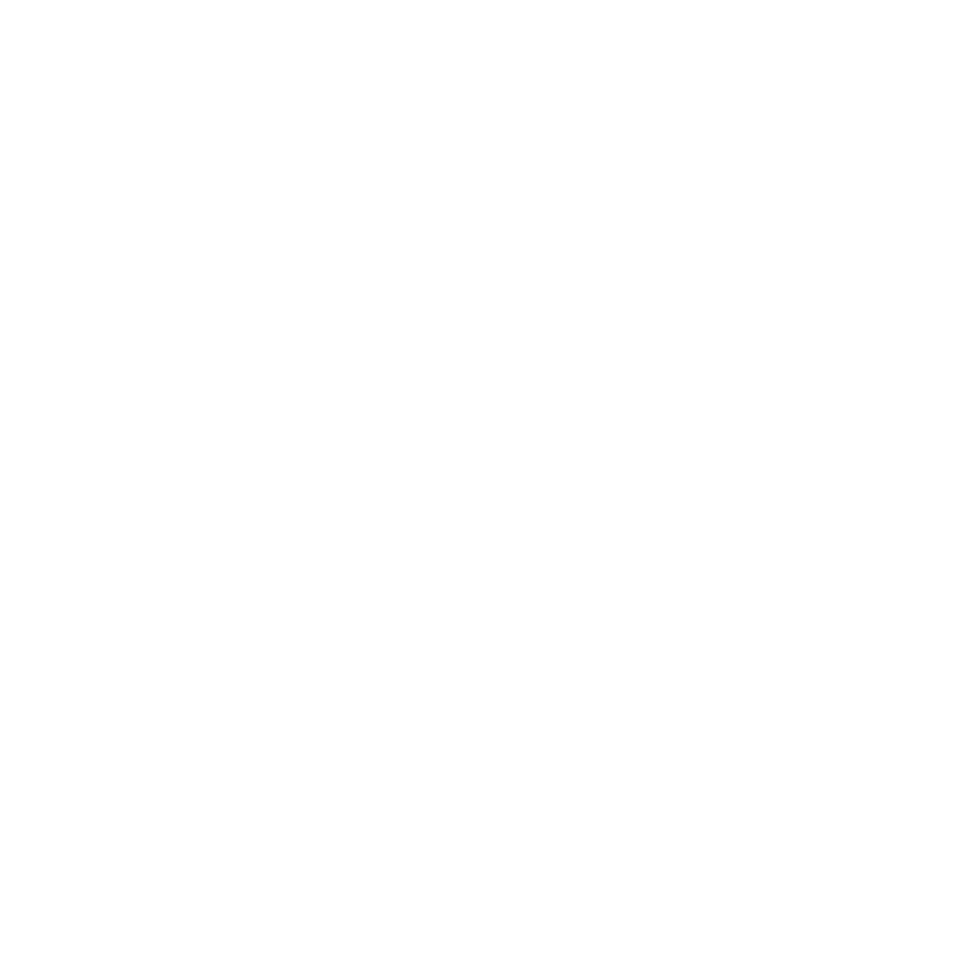

In [1096]:
Tacos['Weighted_Taco_Score'] = (Tacos['Weighted_Taco_Score'] - min(Tacos['Weighted_Taco_Score']))/(max(Tacos['Weighted_Taco_Score']) - min(Tacos['Weighted_Taco_Score']))
GoodTacos = Tacos[Tacos['Weighted_Taco_Score'] > .6]
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(GoodTacos.longitude,GoodTacos.latitude,s=np.exp(5*GoodTacos['Weighted_Taco_Score']),alpha=.5,color='red')
mplleaflet.display(fig=fig)

### The other cool thing we can do is try to find switch points where the distribution parameter changes for reviews. This could be the result of a lot of things - new managment, a new chef, new service. Often times, old reviews of a resturant don't tell us much about what is going on now. Conversely, if a resturant made a recent change, it could be useful for the resturant to monitor whether the change was well or poorly received by the customer base.

### We can use the same methodology to sample from the posterior distribution of the parameters lambda, and introduce a new parameter, t*, which denotes where a possible change in distribution happened.

<IPython.core.display.Javascript object>


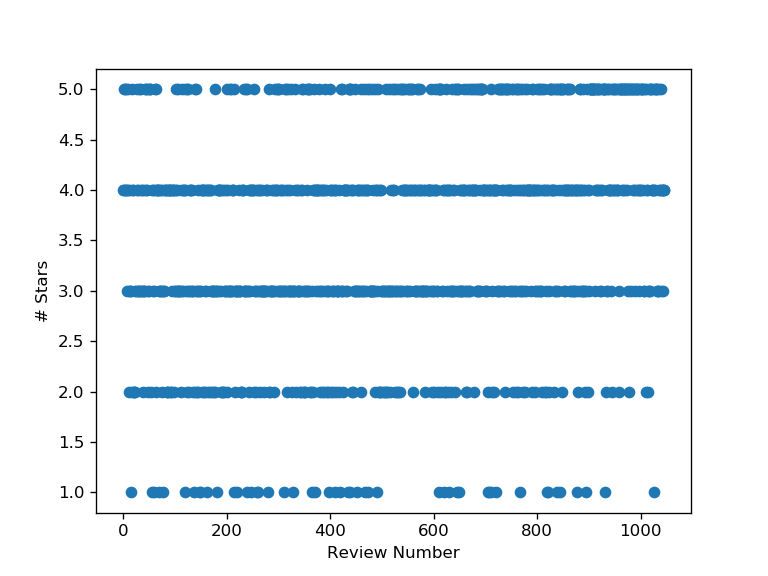

Text(0.5, 0, 'Review Number')

In [1061]:
top_business = Toronto['business_id'].value_counts().head().index.tolist()[3]
stars = Toronto[Toronto['business_id'] == top_business].sort_values('date').stars_y.tolist()
dates = np.linspace(0,len(stars)-1,len(stars))
plt.figure()
plt.plot(dates,stars,'o')
plt.ylabel('# Stars')
plt.xlabel('Review Number')

### By eye, it looks like the reviews got better over time. Can we test this?

In [1064]:
with pm.Model() as test_model:
    # Prior for the time of splitting segment
    tStar1 = pm.Uniform('tStar1',200, 800) #Slightly informative prior
    
    
    # Prior for the probability of lambda in each segment
    lam = pm.Uniform('lam',0,10,shape=2)

   
    grp = (dates > tStar1)*1 
    
    y_obs = pm.Potential('y_obs',likelihood(lam[grp],np.array(stars)-1))

    
with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)
    


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5133.66draws/s]


<IPython.core.display.Javascript object>


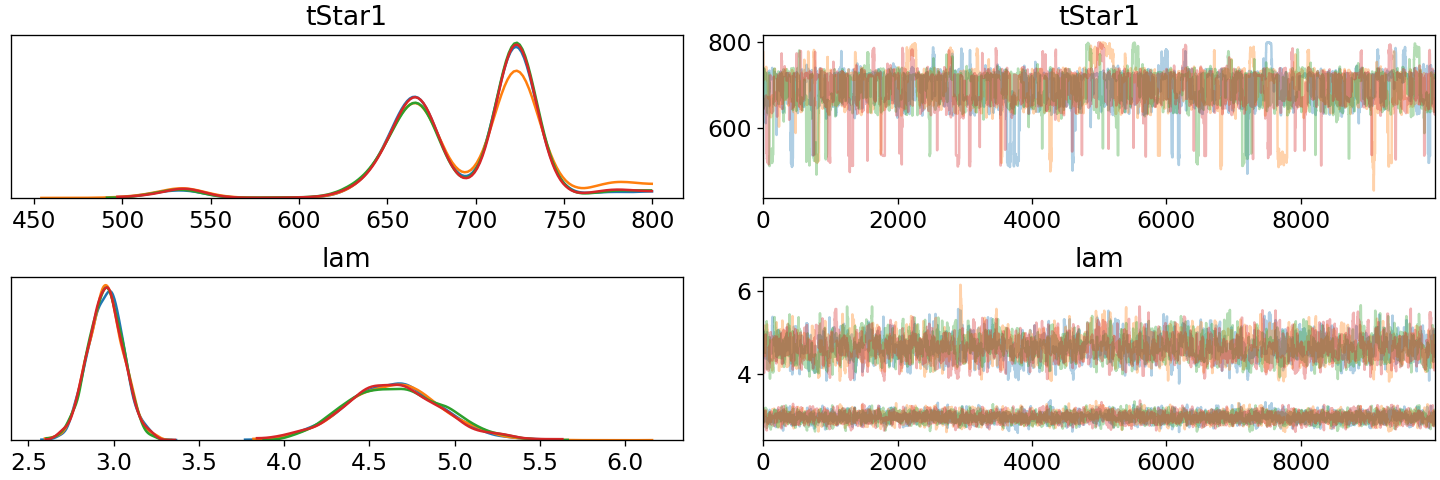

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x27b7c46d8>,
      dtype=object)

In [1065]:
pm.traceplot(trace)

## Multimodal distributions are typical for values of t*, since these reflect discrete events. As we can see, the lambda shifted dramatically after this switch point, and the resturant got better